<a href="https://colab.research.google.com/github/geekpradd/Reinforcement-Learning-Stock-Trader/blob/master/New_Stock_Updated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
import pickle
# COLAB = False
# if not COLAB:
#     import os
#     os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = '/content/drive/My Drive/Stock/'

In [0]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.volume_normal = params['volume_normal']
        self.dfs = df
        self.state_dimensions = self.num_stocks*5+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, self.num_stocks*2), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, intial_balance = 10000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        self.balance = intial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs]).reshape((1, self.num_stocks))
        self.highest_price = np.maximum(self.highest_price, high)

    def observe(self):
        for i in range(self.num_stocks):
            self.frame[0, 4*i:4*i+4] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])/self.highest_price[0, i]
        self.frame[0, self.num_stocks*4:self.num_stocks*5] = self.shares_held/self.shares_normal
        self.frame[0, 5*self.num_stocks] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance += np.sum(action[:, :self.num_stocks]*self.current_price)
        self.balance -= np.sum(action[:, self.num_stocks:])

    def update_shares(self, action):
        self.shares_held -= action[:, :self.num_stocks]
        buy = action[:, self.num_stocks:]/self.current_price
        self.shares_held += buy

    def take_action(self, action):
        action[:, :self.num_stocks] *= self.shares_held
        action[:, self.num_stocks:] *= self.balance
        self.current_price = self.get_price()
        self.set_high()
        self.update_balance(action)
        self.update_shares(action)
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info
        if np.sum(action[:, self.num_stocks:]) > 1:
            print('gadbad')
        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : 2,
        'min_brokerage' : 30.0,
        'brokerage_rate' : 0.001,
        'balance_normal' : 1000000,
        'shares_normal' : 10000,
        'volume_normal' : 2147483647,
    }
    return StockEnv(dfs, params, train)

In [0]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]
        
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [0]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.cap = params['cap']
        self.actor = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=(self.state_dimensions, ))
        x = Dense(60, activation = 'relu')(inputs)
        x = Dense(16, activation = 'relu')(x)
        sell = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        buy = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        final_buy = Activation(tf.keras.activations.softmax)(buy)*tf.math.minimum(self.cap, tf.reduce_sum(buy, axis = -1, keepdims = True))
        model = keras.Model(inputs = inputs, outputs = tf.concat([sell, final_buy], axis = -1))
        # model.summary()
        return model
    
    def get_action(self, state):
        return self.actor(convert(state))

    def save(self):
        self.actor.save(path_base + 'actor.h5')
    
    def load(self):
        self.actor = keras.models.load_model(path_base + 'actor.h5')
        print('Successfully Loaded')

class Critic:
    def __init__(self, params):
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.tau = params['tau']
        self.critic_online = self.build_model()
        self.critic_target = self.build_model()
        self.critic_online.set_weights(self.critic_target.get_weights())

    def build_model(self):
        input_a = Input(shape = (self.state_dimensions, ))
        input_b = Input(shape = (2*self.action_dimensions, ))
        input = Concatenate(axis = -1)([input_a, input_b])
        x = Dense(60, activation = 'relu')(input)
        x = Dense(16, activation = 'relu')(x)
        output = Dense(1)(x)
        model = keras.Model(inputs=[input_a, input_b], outputs = output)
        model.compile(loss='mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
        # model.summary()
        return model

    def save(self):
        self.critic_online.save(path_base + 'critic_online.h5')
        self.critic_target.save(path_base + 'critic_target.h5')

    def load(self):
        self.critic_online = keras.models.load_model(path_base + 'critic_online.h5')
        self.critic_target = keras.models.load_model(path_base + 'critic_target.h5')

    def get_qvalues(self, state_array, action_array, online=True):
        if online:
            return self.critic_online([convert(state_array), convert(action_array)])
        else:
            return self.critic_target([convert(state_array), convert(action_array)])

    def call(self, state_tensor, action_tensor):
        return self.critic_online([state_tensor, action_tensor])
    
    def merge(self):
        self.critic_target.set_weights(self.tau*np.array(self.critic_online.get_weights())
                                                                    + (1-self.tau)*np.array(self.critic_target.get_weights()))

In [0]:
class Agent:
    def __init__(self, params, train = True, resume = True):
        self.train = train
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayMemory(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.cap = params['cap']
        self.num_steps = 0
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(2*params["action_dimensions"]))
        if resume:
            self.load()
        
    def agent_start(self, observation):
        action = self.actor.get_action(observation)
        if self.train:
            action = self.clip_action(action + self.noise_func())
        else:
            action = self.clip_action(action)

        self.prev_state = observation
        self.prev_action = action
        return action

    def clip_action(self, action):
        action = np.clip(action, 0, self.action_range)
        sum = np.sum(action, axis = -1, keepdims = True)
        action = action/sum*np.minimum(sum, self.cap)
        return action

    def agent_step(self, reward, observation):
        if self.train:
            replay = (self.prev_state, self.prev_action, reward, observation)
            self.buffer.append(replay)
        action = self.actor.get_action(observation)
        if self.train:
            action = self.clip_action(action + self.noise_func())
            self.run()
        else:
            action = self.clip_action(action)
        self.prev_action = action
        self.prev_state = observation
        return self.prev_action 
    
    def save(self):
        self.actor.save()
        self.critic.save()
        data = (self.buffer, self.num_steps, self.noise_func)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)

    def load(self):
        self.actor.load()
        self.critic.load()
        with open (path_base + 'auxiliary.pkl', 'rb') as f:
            data = pickle.load(f)
        self.buffer, self.num_steps, self.noise_func = data
    
    def run(self):
        self.num_steps += 1
        size = min(self.batch_size, self.buffer.size)
        batch = self.buffer.sample(size)

        prev_states = np.array([x[0] for x in batch]).reshape((-1, self.state_dimensions))
        prev_actions = np.array([x[1] for x in batch]).reshape((-1, 2*self.action_dimensions))
        rewards = np.array([x[2] for x in batch]).reshape((-1, 1))
        states = np.array([x[3] for x in batch]).reshape((-1, self.state_dimensions))
        actions = self.actor.get_action(states)
        q_values = self.critic.get_qvalues(states, actions, False)
        q_values += self.discount*rewards
        self.critic.critic_online.fit([states, actions], q_values, epochs = 1, verbose=0)

        prev_state_tensor = convert(prev_states)
        prev_action_tensor = convert(prev_actions)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_action_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
        gradient = -tape.gradient(value, prev_action_tensor)
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = tape.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(np.array(gradient_actor)/size)

        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge()

        if self.num_steps % self.save_frequency == 0:
            self.save()

In [0]:
AGENT_PARAMS = {
	"output_range": 1,
	"state_dimensions": 11,
	"action_dimensions": 2,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"batch_size": 64,
	"buffer_size":100000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 5000,
	'cap' : 0.9,
}

In [0]:
files = ['/content/drive/My Drive/AAPL.csv','/content/drive/My Drive/MSFT.csv']
env = create_stock_env(files)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, train = True,resume = False)

In [0]:
def train(agent, env, epochs, profits, balances, shares, actions):

    steps_per_epoch = 2000
    
    for epoch in range(epochs + 1, epochs + 41):

        cumm_profit = 0
        observation, info = env.reset()
        shares[epoch, 0, :] = info['shares_held']
        balances[epoch, 0] = info['balance']
        action = agent.agent_start(observation)
        actions[epoch, 0, :] = action

        for i in tqdm_notebook(range(steps_per_epoch)):

            observation, reward, done, info = env.step(action)
            shares[epoch, i+1, :] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward
            profits[epoch, i] = cumm_profit
            if done:
                break
            action = agent.agent_step(reward, observation)
            actions[epoch, i+1, :] = action

        print('Completed epoch' + str(epoch))

        if epoch % 10 == 0:
            data = epoch, profits, shares, balances, actions
            with open(path_base + 'graph.pkl', 'wb') as f:
                pickle.dump(data, f)

In [0]:
with open(path_base + 'graph.pkl', 'rb') as f:
    data = pickle.load(f)

epochs, profits, balances, shares, actions = data
train(agent, env, epochs, profits, balances, shares, actions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Completed epoch1


Completed epoch2



Completed epoch3



Completed epoch4


Completed epoch5


Completed epoch6


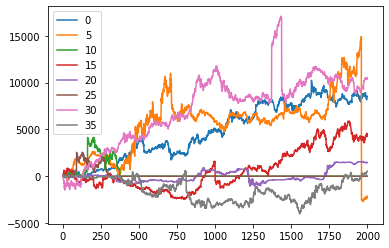

In [0]:
for i in range(0, 40, 5):
    plt.plot(profits[i])

plt.legend(list(range(0, 40, 5)))
plt.show()

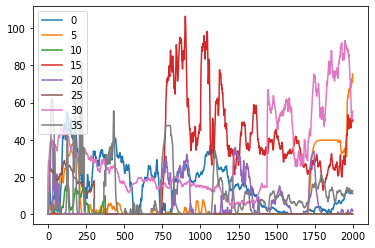

In [0]:
for i in range(0, 40, 5):
    plt.plot(shares[i, :, 0])

plt.legend(list(range(0, 40, 5)))
plt.show()

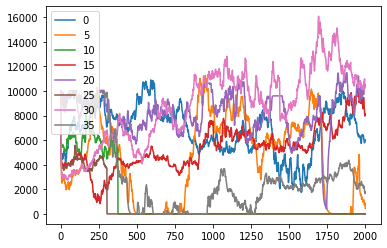

In [0]:
for i in range(0, 40, 5):
    plt.plot(balances[i])

plt.legend(list(range(0, 40, 5)))
plt.show()

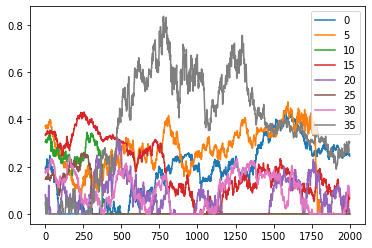

In [0]:
for i in range(0, 40, 5):
    plt.plot(actions[i, :, 3])

plt.legend(list(range(0, 40, 5)))
plt.show()

In [0]:
print(env.net_worth)
print(env.balance)
print(env.shares_held)

18327.28115754672
14641.301327995645
[[9.25150370e-03 4.30073428e+01]]


In [0]:
def test(values):
    num = len(values)
    env = create_stock_env(files, train = False)
    agent = Agent(AGENT_PARAMS, train = False, resume = True)
    print(agent.num_steps)
    max_steps = env.max_steps
    profitst = np.zeros((num, max_steps))
    balancest = np.zeros((num, max_steps + 1))
    sharest = np.zeros((num, max_steps+1, agent.action_dimensions))
    actionst = np.zeros((num, max_steps+1, agent.action_dimensions*2))

    for count, val in enumerate(values):
        profit = 0
        observation, info = env.reset(intial_balance = val, shares_held = np.array([100, 100], dtype = 'float32').reshape((1, 2)))
        balancest[count][0] = info['balance']
        print(info['balance'])
        sharest[count][0] = info['shares_held']
        print(info['shares_held'])
        action = agent.agent_start(observation)
        actionst[count][0] = action

        for i in tqdm_notebook(range(max_steps)):
            observation, reward, done, info = env.step(action)
            profit += reward
            profitst[count][i] = profit
            balancest[count][i+1] = info['balance']
            sharest[count][i+1] = info['shares_held']
            if done:
                break
            action = agent.agent_step(reward, observation)
            actionst[count][i+1] = action
              
        print('Completed' + str(count) + 'values')

    return profitst, balancest, sharest, actionst


In [0]:
values = [1000, 5000, 10000, 20000, 50000]
profitst, balancest, sharest, actionst = test(values)

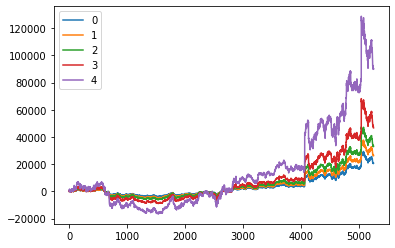

In [0]:
for i in range(5):
    plt.plot(profitst[i])

plt.legend(list(range(5)))
plt.show()

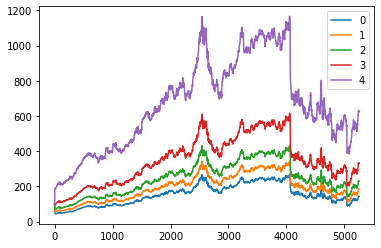

In [0]:
for i in range(5):
    plt.plot(sharest[i, :, 1])

plt.legend(list(range(5)))
plt.show()

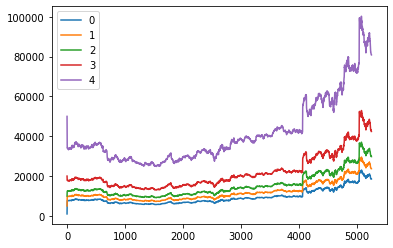

In [0]:
for i in range(5):
    plt.plot(balancest[i])
plt.legend(list(range(5)))
plt.show()